# Training Machine Learing model for ASL inference
## ML Model trained using Yolov5
### ECEN 403 & 404 - Capstone Design Lab - Fall 2022
### Anisha Gollapalli

In [ ]:
# Checking GPU on CoLab

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Fri Oct 28 14:22:06 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# Checking memory 

from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


In [1]:
pwd

'/content'

In [2]:
%cd drive/MyDrive/Anisha/Kaggle-ASL-data/

/content/drive/MyDrive/Anisha/Kaggle-ASL-data


## Download prerequisites

In [ ]:
#!git clone https://github.com/ultralytics/yolov5

In [ ]:
#!pip install -qr yolov5/requirements.txt

     |████████████████████████████████| 1.6 MB 14.0 MB/s 


## Define learning network
### Customising a Yolov5 small model for ASL
### Model summary: 214 layers, 7089751 parameters, 7089751 gradients

In [ ]:
%cat data.yaml

train: ../train/images
val: ../valid/images

nc: 26
names: ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']

In [ ]:
# define number of classes based on data.yaml
import yaml
with open("data.yaml", 'r') as stream:
    num_classes = str(yaml.safe_load(stream)['nc'])

In [ ]:
num_classes

'26'

In [ ]:
%cat yolov5/models/yolov5s.yaml

# YOLOv5 🚀 by Ultralytics, GPL-3.0 license

# Parameters
nc: 80  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 v6.0 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Conv, [64, 6, 2, 2]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, C3, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 6, C3, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, C3, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 3, C3, [1024]],
   [-1, 1, SPPF, [1024, 5]],  # 9
  ]

# YOLOv5 v6.0 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, C3, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]]

In [ ]:
#customize iPython writefile so we can write variables
from IPython.core.magic import register_line_cell_magic

@register_line_cell_magic
def writetemplate(line, cell):
    with open(line, 'w') as f:
        f.write(cell.format(**globals()))

In [ ]:
%%writetemplate yolov5/models/custom_yolov5s.yaml

# Parameters
nc: {num_classes}  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 v6.0 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Conv, [64, 6, 2, 2]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, C3, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 6, C3, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, C3, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 3, C3, [1024]],
   [-1, 1, SPPF, [1024, 5]],  # 9
  ]

# YOLOv5 v6.0 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, C3, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]],  # cat backbone P3
   [-1, 3, C3, [256, False]],  # 17 (P3/8-small)

   [-1, 1, Conv, [256, 3, 2]],
   [[-1, 14], 1, Concat, [1]],  # cat head P4
   [-1, 3, C3, [512, False]],  # 20 (P4/16-medium)

   [-1, 1, Conv, [512, 3, 2]],
   [[-1, 10], 1, Concat, [1]],  # cat head P5
   [-1, 3, C3, [1024, False]],  # 23 (P5/32-large)

   [[17, 20, 23], 1, Detect, [nc, anchors]],  # Detect(P3, P4, P5)
  ]

# Train models

## Model training with 100 epochs and batch size of 32

In [ ]:
%time
%cd yolov5/
!python3 train.py --img 640 --batch 32 --epochs 100 --data '../data.yaml' --cfg ./models/custom_yolov5s.yaml --weights '' --name yolov5s_100_results  --cache

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 6.2 µs
/content/drive/MyDrive/Anisha/Kaggle-ASL-data/yolov5
train: weights=, cfg=./models/custom_yolov5s.yaml, data=../data.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=100, batch_size=32, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=yolov5s_100_results, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: skipping check (not a git repository), for updates see https://github.com/ultralytics/yolov5
requirements: YOLOv5 requirements "ipython" "thop>=0.1.1" not found, attempting AutoUpdate...
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.

## Model training with 300 epochs and batch size of 32

In [3]:
%time
%cd yolov5/
!python3 train.py --img 640 --batch 32 --epochs 300 --data '../data.yaml' --cfg ./models/custom_yolov5s.yaml --weights '' --name yolov5s_300_results  --cache

CPU times: user 1e+03 ns, sys: 1e+03 ns, total: 2 µs
Wall time: 5.01 µs
/content/drive/MyDrive/Anisha/Kaggle-ASL-data/yolov5
train: weights=, cfg=./models/custom_yolov5s.yaml, data=../data.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=300, batch_size=32, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=yolov5s_300_results, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: skipping check (not a git repository), for updates see https://github.com/ultralytics/yolov5
requirements: YOLOv5 requirements "ipython" "thop>=0.1.1" not found, attempting AutoUpdate...
Looking in indexes: https://pypi.org/simple, https://us-py

In [ ]:
cd yolov5

/content/drive/MyDrive/Anisha/Kaggle-ASL-data/yolov5


In [ ]:
!python detect.py --weights runs/train/yolov5s_results5/weights/best.pt --data '../data.yaml' --img 640 --conf 0.4 --source ../test/images

detect: weights=['runs/train/yolov5s_results5/weights/best.pt'], source=../test/images, data=../data.yaml, imgsz=[640, 640], conf_thres=0.4, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 2022-10-17 Python-3.7.15 torch-1.12.1+cu113 CUDA:0 (A100-SXM4-40GB, 40536MiB)

Fusing layers... 
custom_YOLOv5s summary: 157 layers, 7034398 parameters, 0 gradients
image 1/2 /content/drive/MyDrive/Anisha/Kaggle-ASL-data/test/images/A505.jpg: 640x640 1 A, 10.3ms
image 2/2 /content/drive/MyDrive/Anisha/Kaggle-ASL-data/test/images/A605.jpg: 640x640 1 A, 10.3ms
Speed: 0.7ms pre-process, 10.3ms inference, 1.5ms NMS per image at shape (1, 3, 640, 640)
Results saved to runs/detect/exp11


## Model Testing

### Test images

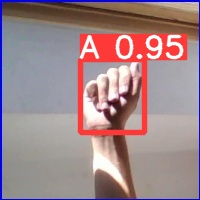

runs/detect/exp11/A505.jpg




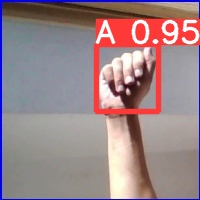

runs/detect/exp11/A605.jpg




In [ ]:
import glob
from IPython.display import Image, display

#for file in '/Users/joshua/Documents/ML/MisbahMohammed/content/yolov5/runs/detect/exp40/*.jpg'
for imageName in sorted(glob.glob('runs/detect/exp11/*.jpg')):
    display(Image(filename=imageName))
    print(imageName)
    print("\n")

### Test camera

In [ ]:
!python3 detect.py --weights runs/train/yolov5s_300_results/weights/best.pt -img 640 --conf-thres 0.8 --source 0

### Test Video

In [ ]:
!python3 detect.py --weights runs/train/yolov5s_300_results/weights/best.pt -img 640 --conf-thres 0.8 --source 'IMG_0679.MOV' --save-txt

### Test streaming YouTube video

In [ ]:
!python3 detect.py --weights runs/train/yolov5s_300_results/weights/best.pt -img 640 --conf-thres 0.8 --source https://www.youtube.com/watch?v=csBb71UPN8E'